# Nobel Twin Familial Cirrhosis Serum Machine Learning Analysis
This workflow looks at creating a machine learning classifier using features from the serum data to classify indivudals with or without advanced fibrosis (AF). I will use the Random Forest Classifier and Logisitic Regression from sklearn. I plan on using Songbird and biological relvance as a way of creating subsets of features. I also plan on using feature importance as a method of feature selection to help improve the Random Forest models. The goal of this analysis is to build on a model off a subset of features that has >60% accuracy in diagnosing AF in individuals.

**Author: Tobin Groth (tgroth@ucsd.edu)**

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import qiime2
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn import metrics
from sklearn.utils import shuffle
import numpy as np
import pylab as pl
import qiime2
import os


os.chdir('/Users/tgroth/Google Drive/knight_twin_NAFLD/serum_analysis')

In [2]:
#loading in fecal metadata
meta = pd.read_csv('../metadata-matched.tsv',sep='\t',index_col=0)
meta.head(3)

,ATTRIBUTE_AgeInYears,ATTRIBUTE_BarcodeSequence,ATTRIBUTE_BiologicalSex,ATTRIBUTE_ChromatographyAndPhase,ATTRIBUTE_ComorbidityListDOIDIndex,ATTRIBUTE_Country,ATTRIBUTE_DOIDCommonName,ATTRIBUTE_DOIDOntologyIndex,ATTRIBUTE_DepthorAltitudeMeters,ATTRIBUTE_Description,...,ATTRIBUTE_waist_circumference_cm,ATTRIBUTE_water_lot,ATTRIBUTE_wbc,ATTRIBUTE_weight,ATTRIBUTE_weight_units,ATTRIBUTE_well_description,ATTRIBUTE_well_id,ATTRIBUTE_zygocity,ATTRIBUTE_zygoticity,filename
sampleid,,,,,,,,,,,,,,,,,,,,,
TW-CO-002,54,TCATGGCCTCCG,male,not applicable,not applicable,United States of America,not applicable,not applicable,200,loomba_nobel_liver,...,98,RNBF9925,8,80.6,kg,Loomba_Twin_Plate_2_TW.CO.002_E2,E2,2,2.0,TW-CO-002_RC4_01_35874.mzXML
TW-BT-001,49,CACACAAAGTCA,female,not applicable,not applicable,United States of America,not applicable,not applicable,200,loomba_nobel_liver,...,92,RNBF9925,8.5,80.8,kg,Loomba_Twin_Plate_2_TW.BT.001_E10,E10,1,1.0,TW-BT-001_RH12_01_35942.mzXML
TW-CA-002,61,TCCGGCGGGCAA,male,not applicable,not applicable,United States of America,not applicable,not applicable,200,loomba_nobel_liver,...,115,RNBF9925,6.2,99.7,kg,Loomba_Twin_Plate_2_TW.CA.002_B10,B10,1,1.0,TW-CA-002_RH6_01_35936.mzXML


In [4]:
#loading in the hashed feature table
serum_table = qiime2.Artifact.load('feature_tables/serum-ft-hashed-matched-clr.qza')
serum_tablepd = serum_table.view(pd.DataFrame)
serum_tablepd.head(3)

,0004069a1f2c3f2b14511a4f367e485d,0013ada35a72573fde974722d6f46269,0074f0d3d22016bcdf28ee53c8a5062b,012ade16945709e69650957b8fdeb021,015bcc773d2fe77d5ddf3533aff00a9f,0171c4a4201b9604da3efc9305fc5264,017460a73612042af020d72a944567b4,01809bb355414a0015fd764cba9c5014,01a15bb425333e9bb45a57970a4fd744,01f940cc9606a206fc0f5f4be686142a,...,fe8cbb81d1abec83ba4cc2e9f82dd552,febe3e034a4a2cb784dec089610dd34c,fecd9732b400a12637130cb39f076b17,ff0f37b5dc7b583b0990818a3ca3bd85,ff47eed94e12e32213900023846a2b25,fface4fa9e4315823b284edf46814f27,ffc858cfa01fda2a2b2c0a1344a0b87a,ffe5d35f6eb7b6d40c0b901f6576ca3c,ffeb115b9cba8e7fde3b05c27b47a913,fff8ef7ac71077d6ddc2c538ad270385
TW-CO-002,2.419473,1.228468,2.735623,0.552462,0.665872,-3.353762,4.411967,1.195942,2.533593,-4.500389,...,-4.500389,1.640413,0.565009,-0.636114,0.509192,-3.758311,-3.210960,-1.238813,1.881735,-4.500389
TW-BT-001,2.631422,1.308736,1.621244,1.440879,4.530231,-3.370700,5.797044,1.065689,2.149651,-4.641508,...,-4.641508,1.653232,0.799320,-0.704906,-0.681992,-3.835060,-4.281300,-1.298801,3.040965,-4.641508
TW-CA-002,0.633377,0.573870,1.629039,1.168365,2.959648,-3.846892,4.457557,1.681721,2.191344,-3.212365,...,-4.647163,2.008481,1.310051,-1.155358,-1.772491,-4.647163,5.717199,-0.000126,1.042010,-4.647163


# 1. Building Baseline Models

## 1a. Cross Validating and Training on G1P+G3P 

In [5]:
# get all the samples that are either in group G1P G3P
samples_train = ([idx for idx in meta[meta.ATTRIBUTE_groups=='G1P'].index]
            + [idx for idx in meta[meta.ATTRIBUTE_groups=='G3P'].index])
exp_train = meta.loc[samples_train][['ATTRIBUTE_groups','ATTRIBUTE_adv_fibrosis']]
exp_train.rename(columns={'ATTRIBUTE_groups':'groups','ATTRIBUTE_adv_fibrosis':'adv_fibrosis'},inplace=True)
print(exp_train.groups.value_counts())
print(exp_train.adv_fibrosis.value_counts())

G1P    48
G3P    22
Name: groups, dtype: int64
0                         44
1                         22
Missing: Not collected     4
Name: adv_fibrosis, dtype: int64


Can see the 4 Missing: Not collected individuals are from G1P and therefore are 0 for AF

**Large difference in group size, will use precision-recall curve for plotting accuracy of models**

In [6]:
#preparing training data for base model
x_train_base = serum_tablepd.loc[exp_train.index]
#label encoder
y_train_base = []
for idx in exp_train.index:
    if exp_train.loc[idx,'adv_fibrosis'] == '1':
        y_train_base.append(1)
    #values that are 'missing' are still 0 for adv fibrosis
    else:
        y_train_base.append(0)
y_train_base = np.array(y_train_base)
print(len(x_train_base.index))
print(len(y_train_base))

70
70


In [7]:
#creating method for cross validating model by plotting ROC
#cf==0 for log reg, cf==1 for RF
def cross_val_roc(cf, x_train, y_train, title, split=5,):
    from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import roc_curve, auc

    
    fig = plt.figure()
    ax = plt.subplot(111)
    
    # Run classifier with crossvalidation and plot ROC curves
    cv =StratifiedShuffleSplit(n_splits=split, test_size=0.3, random_state=9)
    if cf == 0:
        cf_test1 = LogisticRegression(random_state=0,max_iter=500)
    else:
        cf_test1 = RandomForestClassifier(n_estimators=500, n_jobs=4, random_state=0)

    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []
    for train, test in cv.split(x_train,y_train):
        probas_ = cf_test1.fit(x_train.iloc[train], y_train[train]).predict_proba(x_train.iloc[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y_train[test], probas_[:,1])
        mean_tpr += np.interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        pl.plot(fpr, tpr, lw=1, label='ROC (area = %0.2f)' %  roc_auc)

    pl.plot([0, 1], [0, 1], '--', color=(0.6,0.6,0.6), label='Luck')
    mean_tpr /= cv.get_n_splits()
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    pl.plot(mean_fpr, mean_tpr, 'k--',
            label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

    pl.xlim([-0.05,1.05])
    pl.ylim([-0.05,1.05])
    pl.xlabel('False Positive Rate')
    pl.ylabel('True Positive Rate')
    pl.title(title)
    ax.legend(bbox_to_anchor=(1, 1))
    return pl

In [8]:
#creating method for cross validating model by plotting Precision-Recall curve
#cf==0 for log reg, cf==1 for RF
def cross_val_pr(cf, x_train, y_train, title, split=5,):
    from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
    from sklearn.metrics import precision_recall_curve
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import roc_curve, auc
    from scipy import interp

    
    fig = plt.figure()
    ax = plt.subplot(111)
    
    # Run classifier with crossvalidation and plot precision-recall curves
    cv =StratifiedShuffleSplit(n_splits=split, test_size=0.4, random_state=9)
    if cf == 0:
        cf_test1 = LogisticRegression(random_state=0,max_iter=500)
    else:
        cf_test1 = RandomForestClassifier(n_estimators=500, n_jobs=4, random_state=0)

    mean_precision = 0.0
    mean_recall = np.linspace(1, 0, 100)
    all_precision = []

    for train, test in cv.split(x_train,y_train):
        probas_ = cf_test1.fit(x_train.iloc[train], y_train[train]).predict_proba(x_train.iloc[test])
        # Compute precision-recall curve and area the curve
        precision, recall, thresholds = precision_recall_curve(y_train[test], probas_[:,1])
        #fpr, tpr, thresholds = roc_curve(y_train[test], probas_[:,1])
        rev_recall = recall[::-1]
        rev_precision = precision[::-1]
        mp = np.interp(mean_recall, rev_recall, rev_precision)
        #print(mp)
        mean_precision += mp
        #mean_precision[0] = 1.0
        pr_auc = auc(rev_recall, rev_precision)
        plt.plot(recall, precision, lw=1, label='Precision-Recall (area = %0.2f)' %  pr_auc)

    #plt.plot([0, 1], [1, 0], '--', color=(0.6,0.6,0.6), label='Luck')

    mean_precision /= cv.get_n_splits()
    #mean_precision[-1] = 1.0
    mean_auc = auc(mean_recall, mean_precision)
    #print(mean_recall)
    #print(mean_precision)
    plt.plot(mean_recall, mean_precision, 'k--',
            label='Mean Precision-Recall (area = %0.2f)' % mean_auc, lw=2)

    plt.xlim([-0.05,1.05])
    plt.ylim([-0.05,1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    ax.legend(bbox_to_anchor=(1, 1))
    #plt.legend(loc="lower right")
    return plt

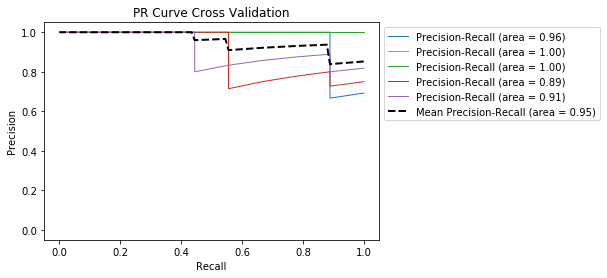

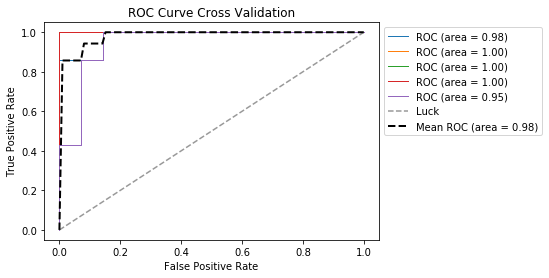

In [9]:
#plotting Precision-recall for Log Reg
lr_fig = cross_val_pr(0,x_train_base,y_train_base,'PR Curve Cross Validation')
lr_fig.savefig('./ml_analysis/featImp_analysis/clr_figures/lr_base_cv_pr.pdf',bbox_inches='tight')

lr_fig = cross_val_roc(0,x_train_base,y_train_base,'ROC Curve Cross Validation')
lr_fig.savefig('./ml_analysis/featImp_analysis/clr_figures/lr_base_cv_roc.pdf',bbox_inches='tight')

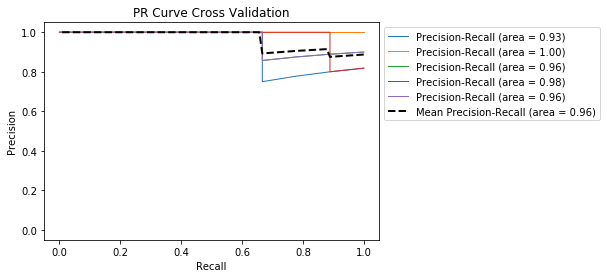

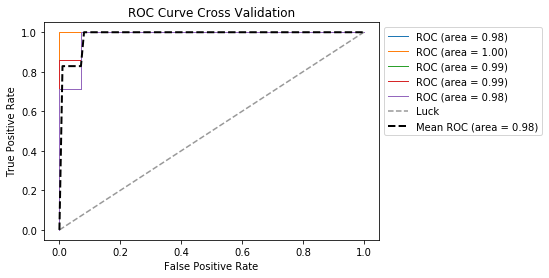

In [10]:
#plott prevision recall for Random Forest
rf_fig = cross_val_pr(1,x_train_base,y_train_base,'PR Curve Cross Validation')
rf_fig.savefig('./ml_analysis/featImp_analysis/clr_figures/rf_base_cv_pr.pdf',bbox_inches='tight')

rf_fig = cross_val_roc(1,x_train_base,y_train_base,'ROC Curve Cross Validation')
rf_fig.savefig('./ml_analysis/featImp_analysis/clr_figures/rf_base_cv_roc.pdf',bbox_inches='tight')

In [11]:
#training Log Reg on training data
base_lr = LogisticRegression(random_state=0,max_iter=200)
base_lr.fit(x_train_base, y_train_base)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [12]:
#training RF on training data
base_rf = RandomForestClassifier(500, oob_score=True, random_state=0)
base_rf.fit(x_train_base, y_train_base)
base_rf.oob_score_

0.9571428571428572

## 1b. Testing models on G3R

In [13]:
# get all the samples that are G3R
samples_test = [idx for idx in meta[meta.ATTRIBUTE_groups=='G3R'].index if idx in fecal_tablepd.index]
exp_test = meta.loc[samples_test][['ATTRIBUTE_groups','ATTRIBUTE_adv_fibrosis']]
exp_test.rename(columns={'ATTRIBUTE_groups':'groups','ATTRIBUTE_adv_fibrosis':'adv_fibrosis'},inplace=True)
#have to drop Missing: Not collected values
exp_test = exp_test[exp_test.adv_fibrosis != 'Missing: Not collected']
print(exp_test.adv_fibrosis.value_counts())

0    21
1     7
Name: adv_fibrosis, dtype: int64


In [14]:
# Preparing the test data for BAB and SB
x_test_base = serum_tablepd.loc[exp_test.index]
y_test_base = []
for idx in exp_test.index:
    if exp_test.loc[idx,'adv_fibrosis'] == '1':
        y_test_base.append(1)
    elif exp_test.loc[idx,'adv_fibrosis'] == '0':
        y_test_base.append(0)
y_test_base = np.array(y_test_base)
print(len(x_test_base))
print(len(y_test_base))

28
28


In [15]:
#plotting Precision Recall curve 
#(code used from calour.plot_roc http://biocore.github.io/calour/generated/calour.training.plot_roc.html)
def plot_result_pr(result,title,cv=True):
    from sklearn import metrics
    from matplotlib import pyplot as plt
    import itertools
    
    cmap = plt.cm.Dark2
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    #ax.plot([0, 1], [0, 1], linestyle='-', lw=1, color='black', label='Luck', alpha=.5)

    classes = np.unique(result['Y_TRUE'].values)
    classes.sort()

    col = dict(zip(classes, itertools.cycle(cmap.colors)))

    mean_recall = np.linspace(1, 0, 100)
    for cls in classes:
        precisions = []
        aucs = []
        if cv is True:
            for grp, df in result.groupby('CV'):
                y_true = df['Y_TRUE'].values == cls
                precision, recall, thresholds = metrics.precision_recall_curve(y_true.astype(int), result[cls])
                rev_recall = recall[::-1]
                rev_precision = precision[::-1]
                mean_precision = np.interp(mean_recall, rev_recall, rev_precision)
                precisions.append(mean_precision)
                precisions[-1][0] = 0.0
                pr_auc = metrics.auc(mean_recall, mean_precision)
                aucs.append(pr_auc)

            mean_precision = np.mean(precisions, axis=0)
            #mean_tpr[-1] = 1.0
            mean_auc = np.mean(aucs)
            std_auc = np.std(aucs)
            ax.plot(mean_recall, mean_precision, color=col[cls],
                    label='{0} ({1:.2f} $\\pm$ {2:.2f})'.format(cls, mean_auc, std_auc),
                    lw=2, alpha=.8)

            std_precision = np.std(precisions, axis=0)
            precisions_upper = np.minimum(mean_precision + std_precision, 1)
            precisions_lower = np.maximum(mean_precision - std_precision, 0)
            ax.fill_between(mean_recall, precisions_lower, precisions_upper, color=col[cls], alpha=.5)
        else:
            y_true = result['Y_TRUE'].values == cls
            precision, recall, thresholds = metrics.precision_recall_curve(y_true.astype(int), result[cls])
            pr_auc = auc(recall, precision)
            # prepend zero because, if not, the curve may start in the middle of the plot.
            ax.plot(np.insert(recall, 0, 0), np.insert(precision, 0, 0), label='{0} ({1:.2f})'.format(cls, pr_auc), lw=2)

    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.05)
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title(title)
    ax.legend(loc="lower right")

    #return ax, mean_auc if cv else pr_auc
    return plt

In [16]:
#plotting ROC curve 
#(code used from calour.plot_roc http://biocore.github.io/calour/generated/calour.training.plot_roc.html)
def plot_result_roc(result,title,cv=True):    
    from sklearn import metrics
    from matplotlib import pyplot as plt
    import itertools
    
    cmap = plt.cm.Dark2
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.plot([0, 1], [0, 1], linestyle='-', lw=1, color='black', label='Luck', alpha=.5)

    classes = np.unique(result['Y_TRUE'].values)
    classes.sort()

    col = dict(zip(classes, itertools.cycle(cmap.colors)))

    mean_fpr = np.linspace(0, 1, 100)
    for cls in classes:
        tprs = []
        aucs = []
        if cv is True:
            for grp, df in result.groupby('CV'):
                y_true = df['Y_TRUE'].values == cls
                fpr, tpr, thresholds = metrics.roc_curve(y_true.astype(int), df[cls])
                mean_tpr = np.interp(mean_fpr, fpr, tpr)
                tprs.append(mean_tpr)
                tprs[-1][0] = 0.0
                roc_auc = metrics.auc(mean_fpr, mean_tpr)
                aucs.append(roc_auc)

            mean_tpr = np.mean(tprs, axis=0)
            mean_tpr[-1] = 1.0
            mean_auc = np.mean(aucs)
            std_auc = np.std(aucs)
            ax.plot(mean_fpr, mean_tpr, color=col[cls],
                    label='{0} ({1:.2f} $\\pm$ {2:.2f})'.format(cls, mean_auc, std_auc),
                    lw=2, alpha=.8)

            std_tpr = np.std(tprs, axis=0)
            tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
            tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
            ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color=col[cls], alpha=.5)
        else:
            y_true = result['Y_TRUE'].values == cls
            fpr, tpr, thresholds = roc_curve(y_true.astype(int), result[cls])
            roc_auc = auc(fpr, tpr)
            # prepend zero because, if not, the curve may start in the middle of the plot.
            ax.plot(np.insert(fpr, 0, 0), np.insert(tpr, 0, 0), label='{0} ({1:.2f})'.format(cls, roc_auc), lw=2)

    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.05)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(title)
    ax.legend(loc="lower right")

    #return ax, mean_auc if cv else roc_auc
    return plt

In [17]:
#testing the logistic regression base model
result_base_lr = pd.DataFrame(base_lr.predict_proba(x_test_base))
result_base_lr.columns = base_lr.classes_
result_base_lr['Y_TRUE'] = y_test_base
result_base_lr['CV'] = 0

Average precision-recall score: 0.26


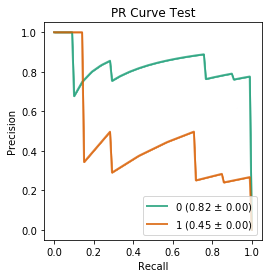

In [18]:
fig_base_lr = plot_result_pr(result_base_lr,'PR Curve Test')
fig_base_lr.savefig('./ml_analysis/featImp_analysis/clr_figures/lr_base_test_pr.pdf',bbox_inches='tight')

average_precision = metrics.average_precision_score(y_test_base, base_lr.predict(x_test_base))

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Accuracy score: 0.29


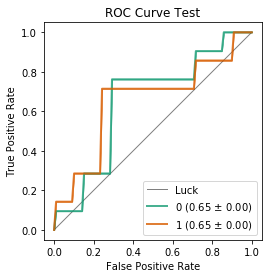

In [19]:
fig_base_lr = plot_result_roc(result_base_lr,'ROC Curve Test')
fig_base_lr.savefig('./ml_analysis/featImp_analysis/clr_figures/lr_base_test_roc.pdf',bbox_inches='tight')

acc_score = metrics.accuracy_score(y_test_base, base_lr.predict(x_test_base))

print('Accuracy score: {0:0.2f}'.format(
      acc_score))

In [20]:
#testing the random forest base model
result_base_rf = pd.DataFrame(base_rf.predict_proba(x_test_base))
result_base_rf.columns = base_rf.classes_
result_base_rf['Y_TRUE'] = y_test_base
result_base_rf['CV'] = 0

Average precision-recall score: 0.25


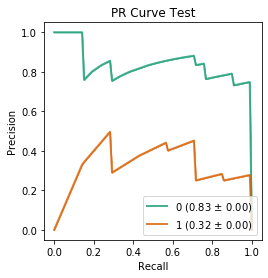

In [21]:
fig_base_rf = plot_result_pr(result_base_rf,'PR Curve Test')
fig_base_rf.savefig('./ml_analysis/featImp_analysis/clr_figures/rf_base_test_pr.pdf',bbox_inches='tight')

average_precision = metrics.average_precision_score(y_test_base, base_rf.predict(x_test_base))

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Accuracy score: 0.32


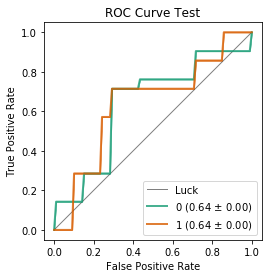

In [22]:
fig_base_rf = plot_result_roc(result_base_rf,'ROC Curve Test')
fig_base_rf.savefig('./ml_analysis/featImp_analysis/clr_figures/rf_base_test_roc.pdf',bbox_inches='tight')

acc_score = metrics.accuracy_score(y_test_base, base_rf.predict(x_test_base))

print('Accuracy score: {0:0.2f}'.format(
      acc_score))

**Next we will use feature importance to select features to see if that can improve our model**

In [23]:
# extracting the important features from our classifier
base_fimp1 = pd.Series(base_rf.feature_importances_).sort_values(ascending=False)
base_fimp1 = base_fimp1.to_frame()
base_fimp1.columns = ['imp_score']
base_fimp1.head(5)

,imp_score
407,0.027903
1097,0.021265
1818,0.021119
591,0.019307
492,0.017828


In [24]:
# extracting the features that have a feature importance over the threshold of 0.01
top_feat1 = list(base_fimp1[base_fimp1['imp_score']>0.005].index)
print('There are %d features with importance >0.005' %len(top_feat1))

There are 47 features with importance >0.005


## 2. Building New Models Using Selected Features

### 2a. CV/Train model on G1P+G3P

In [25]:
#getting samples to 
exp_train.groups.value_counts()

G1P    48
G3P    22
Name: groups, dtype: int64

In [26]:
#preparing training data
x_train_feat1 = serum_tablepd.loc[exp_train.index]
x_train_feat1 = x_train_feat1.iloc[:,top_feat1]
#label encoder
y_train_feat1 = []
for idx in exp_train.index:
    if exp_train.loc[idx,'adv_fibrosis'] == '1':
        y_train_feat1.append(1)
    #even values that are 'missing' are still 0 for adv fibrosis
    else:
        y_train_feat1.append(0)
y_train_feat1 = np.array(y_train_feat1)
#ensuring we have correct samples x features
print(x_train_feat1.shape)
print(len(y_train_feat1))

(70, 47)
70


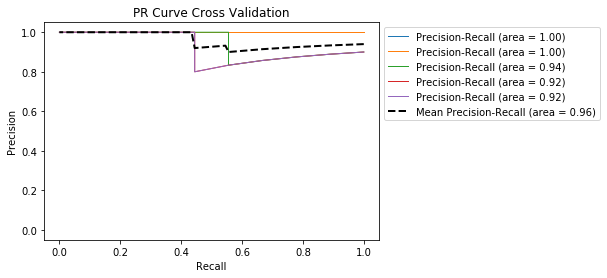

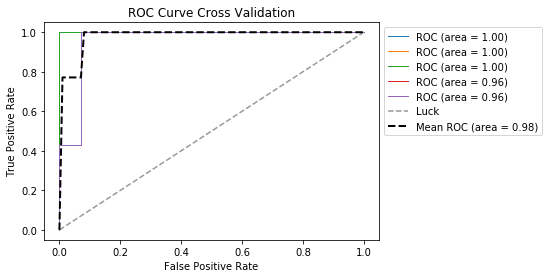

In [27]:
fig_lr = cross_val_pr(0,x_train_feat1,y_train_feat1,'PR Curve Cross Validation')
fig_lr.savefig('ml_analysis/featImp_analysis/clr_figures/lr_selected_cv_pr.pdf',bbox_inches='tight')

fig_lr = cross_val_roc(0,x_train_feat1,y_train_feat1,'ROC Curve Cross Validation')
fig_lr.savefig('ml_analysis/featImp_analysis/clr_figures/lr_selected_cv_roc.pdf',bbox_inches='tight')

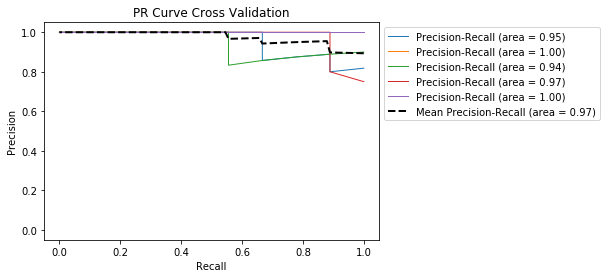

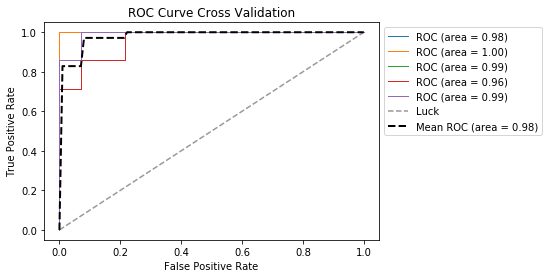

In [28]:
fig_rf = cross_val_pr(1,x_train_feat1,y_train_feat1,'PR Curve Cross Validation')
fig_rf.savefig('ml_analysis/featImp_analysis/clr_figures/rf_selected_cv_pr.pdf',bbox_inches='tight')

fig_rf = cross_val_roc(1,x_train_feat1,y_train_feat1,'ROC Curve Cross Validation')
fig_rf.savefig('ml_analysis/featImp_analysis/clr_figures/rf_selected_cv_roc.pdf',bbox_inches='tight')


In [29]:
#training Log Reg on training data
feat1_lr = LogisticRegression(random_state=0,max_iter=200)
feat1_lr.fit(x_train_feat1, y_train_feat1)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [30]:
#training RF on training data
feat1_rf = RandomForestClassifier(500, oob_score=True, random_state=0)
feat1_rf.fit(x_train_feat1, y_train_feat1)
feat1_rf.oob_score_

0.9714285714285714

### 2b. Testing Models on G3R Samples

In [31]:
exp_test.adv_fibrosis.value_counts()

0    21
1     7
Name: adv_fibrosis, dtype: int64

In [32]:
# Preparing the test data
x_test_feat1 = serum_tablepd.loc[exp_test.index]
x_test_feat1 = x_test_feat1.iloc[:,top_feat1]
y_test_feat1 = []
for idx in exp_test.index:
    if exp_test.loc[idx,'adv_fibrosis'] == '1':
        y_test_feat1.append(1)
    elif exp_test.loc[idx,'adv_fibrosis'] == '0':
        y_test_feat1.append(0)
y_test_feat1 = np.array(y_test_feat1)
print(x_test_feat1.shape)
print(len(y_test_feat1))

(28, 47)
28


In [33]:
#testing log reg
result_feat1_lr = pd.DataFrame(feat1_lr.predict_proba(x_test_feat1))
result_feat1_lr.columns = feat1_lr.classes_
result_feat1_lr['Y_TRUE'] = y_test_feat1
result_feat1_lr['CV'] = 0

Average precision-recall score: 0.28


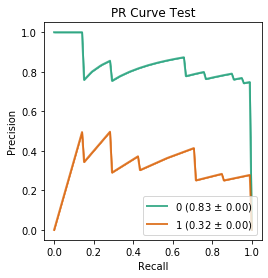

In [34]:
fig_feat1_lr = plot_result_pr(result_feat1_lr,'PR Curve Test')
fig_feat1_lr.savefig('ml_analysis/featImp_analysis/clr_figures/lr_selected_test_pr.pdf',bbox_inches='tight')

average_precision = metrics.average_precision_score(y_test_feat1, feat1_lr.predict(x_test_feat1))

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Accuracy score: 0.36


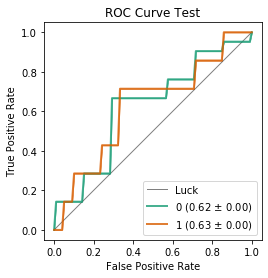

In [35]:
fig_feat1_lr = plot_result_roc(result_feat1_lr,'ROC Curve Test')
fig_feat1_lr.savefig('ml_analysis/featImp_analysis/clr_figures/lr_selected_test_roc.pdf',bbox_inches='tight')

acc_score = metrics.accuracy_score(y_test_feat1, feat1_lr.predict(x_test_feat1))

print('Accuracy score: {0:0.2f}'.format(
      acc_score))

In [36]:
#testing the random forest selected feature model
result_feat1_rf = pd.DataFrame(feat1_rf.predict_proba(x_test_feat1))
result_feat1_rf.columns = feat1_rf.classes_
result_feat1_rf['Y_TRUE'] = y_test_feat1
result_feat1_rf['CV'] = 0

Average precision-recall score: 0.27


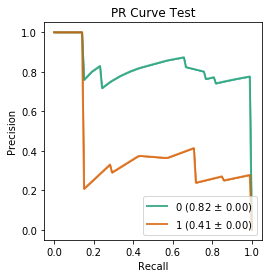

In [37]:
fig_feat1_rf = plot_result_pr(result_feat1_rf,'PR Curve Test')
fig_feat1_rf.savefig('ml_analysis/featImp_analysis/clr_figures/rf_selected_test_pr.pdf',bbox_inches='tight')

average_precision = metrics.average_precision_score(y_test_feat1, feat1_rf.predict(x_test_feat1))

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Accuracy score: 0.39


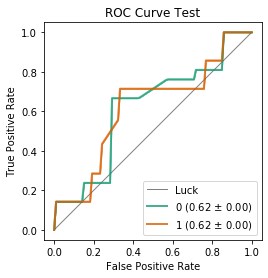

In [38]:
fig_feat1_rf = plot_result_roc(result_feat1_rf,'ROC Curve Test')
fig_feat1_rf.savefig('ml_analysis/featImp_analysis/clr_figures/rf_selected_test_roc.pdf',bbox_inches='tight')

acc_score = metrics.accuracy_score(y_test_feat1, feat1_rf.predict(x_test_feat1))

print('Accuracy score: {0:0.2f}'.format(
      acc_score))

In [39]:
## extracting the important features from our classifier
base_fimp2 = pd.Series(feat1_rf.feature_importances_).sort_values(ascending=False)
base_fimp2 = base_fimp2.to_frame()
base_fimp2.columns = ['imp_score']
base_fimp2.shape

(47, 1)

In [40]:
# extracting the features that have a feature importance over the threshold of 0.02
top_feat2 = list(base_fimp2[base_fimp2['imp_score']>0.02].index)
top_feat2 = x_test_feat1.iloc[:,top_feat2].columns
print('There are %d features with importance >0.02' %len(top_feat2))

There are 19 features with importance >0.02


## 3. Building Models Using Further Selected Features

### 3a. CV/Train Model on G1P+G3P data

In [41]:
exp_train.groups.value_counts()

G1P    48
G3P    22
Name: groups, dtype: int64

In [42]:
#preparing training data
x_train_feat2 = serum_tablepd.loc[exp_train.index]
x_train_feat2 = x_train_feat2.loc[:,top_feat2]
#label encoder
y_train_feat2 = []
for idx in exp_train.index:
    if exp_train.loc[idx,'adv_fibrosis'] == '1':
        y_train_feat2.append(1)
    #even values that are 'missing' are still 0 for adv fibrosis
    else:
        y_train_feat2.append(0)
y_train_feat2 = np.array(y_train_feat2)
#ensuring we have correct samples x features
print(x_train_feat2.shape)
print(len(y_train_feat2))

(70, 19)
70


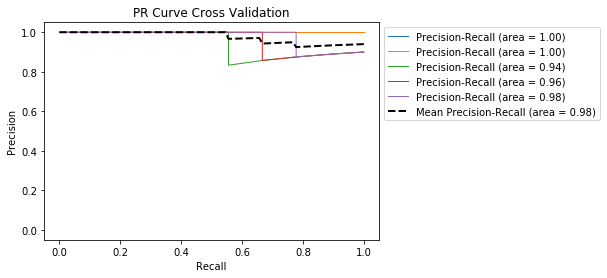

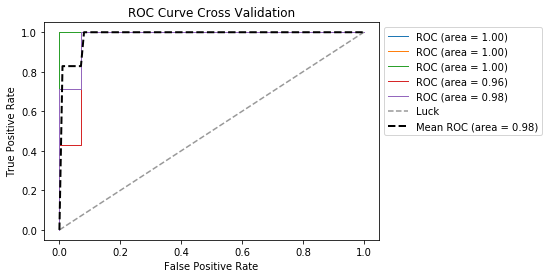

In [43]:
fig_lr = cross_val_pr(0,x_train_feat2,y_train_feat2,'PR Curve Cross Validation')
fig_lr.savefig('ml_analysis/featImp_analysis/clr_figures/lr_fselected_cv_pr.pdf',bbox_inches='tight')

fig_lr = cross_val_roc(0,x_train_feat2,y_train_feat2,'ROC Curve Cross Validation')
fig_lr.savefig('ml_analysis/featImp_analysis/clr_figures/lr_fselected_cv_roc.pdf',bbox_inches='tight')


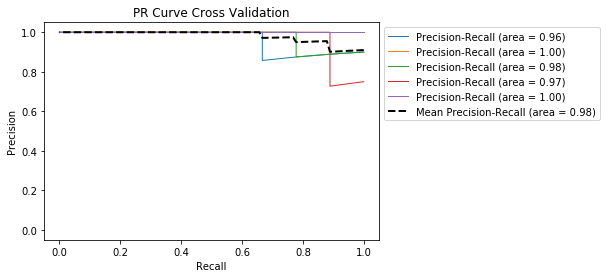

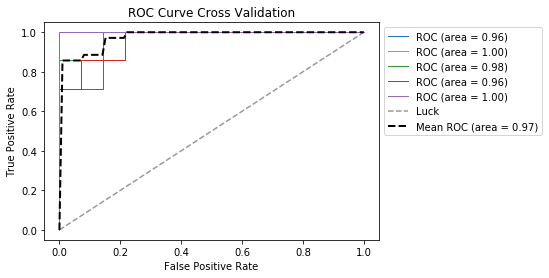

In [44]:
fig_rf = cross_val_pr(1,x_train_feat2,y_train_feat2,'PR Curve Cross Validation')
fig_rf.savefig('ml_analysis/featImp_analysis/clr_figures/rf_fselected_cv_pr.pdf',bbox_inches='tight')

fig_rf = cross_val_roc(1,x_train_feat2,y_train_feat2,'ROC Curve Cross Validation')
fig_rf.savefig('ml_analysis/featImp_analysis/clr_figures/rf_fselected_cv_roc.pdf',bbox_inches='tight')


In [45]:
#training Log Reg on training data
feat2_lr = LogisticRegression(random_state=0,max_iter=200)
feat2_lr.fit(x_train_feat2, y_train_feat2)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [46]:
#training RF on training data
feat2_rf = RandomForestClassifier(500, oob_score=True, random_state=0)
feat2_rf.fit(x_train_feat2, y_train_feat2)
feat2_rf.oob_score_

0.9571428571428572

### 3b. Testing Models on G3R data

In [47]:
exp_test.adv_fibrosis.value_counts()

0    21
1     7
Name: adv_fibrosis, dtype: int64

In [48]:
# Preparing the test data
x_test_feat2 = serum_tablepd.loc[exp_test.index]
x_test_feat2 = x_test_feat2.loc[:,top_feat2]
y_test_feat2 = []
for idx in exp_test.index:
    if exp_test.loc[idx,'adv_fibrosis'] == '1':
        y_test_feat2.append(1)
    elif exp_test.loc[idx,'adv_fibrosis'] == '0':
        y_test_feat2.append(0)
y_test_feat2 = np.array(y_test_feat2)
print(x_test_feat2.shape)
print(len(y_test_feat2))

(28, 19)
28


In [49]:
#testing log reg
result_feat2_lr = pd.DataFrame(feat2_lr.predict_proba(x_test_feat2))
result_feat2_lr.columns = feat2_lr.classes_
result_feat2_lr['Y_TRUE'] = y_test_feat2
result_feat2_lr['CV'] = 0

Average precision-recall score: 0.26


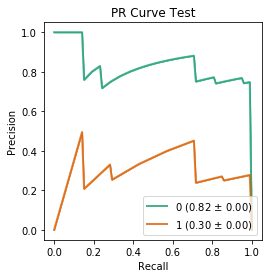

In [50]:
#showing Precision-recall results
fig_feat2_lr = plot_result_pr(result_feat2_lr,'PR Curve Test')
fig_feat2_lr.savefig('ml_analysis/featImp_analysis/clr_figures/lr_fselected_test_pr.pdf',bbox_inches='tight')

average_precision = metrics.average_precision_score(y_test_feat2, feat2_lr.predict(x_test_feat2))

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Accuracy score: 0.36


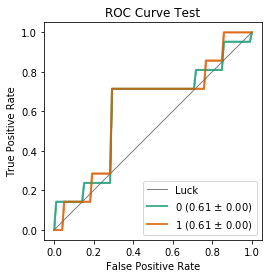

In [51]:
#showing accuracy/ROC results
fig_feat2_lr = plot_result_roc(result_feat2_lr,'ROC Curve Test')
fig_feat2_lr.savefig('ml_analysis/featImp_analysis/clr_figures/lr_fselected_test_roc.pdf',bbox_inches='tight')

acc_score = metrics.accuracy_score(y_test_feat2, feat2_lr.predict(x_test_feat2))

print('Accuracy score: {0:0.2f}'.format(
      acc_score))

In [52]:
#testing random forest
result_feat2_rf = pd.DataFrame(feat2_rf.predict_proba(x_test_feat2))
result_feat2_rf.columns = feat2_rf.classes_
result_feat2_rf['Y_TRUE'] = y_test_feat2
result_feat2_rf['CV'] = 0

Average precision-recall score: 0.27


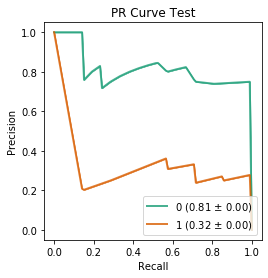

In [53]:
#showing Precision-recall results
fig_feat2_rf = plot_result_pr(result_feat2_rf,'PR Curve Test')
fig_feat2_rf.savefig('ml_analysis/featImp_analysis/clr_figures/rf_fselected_test_pr.pdf',bbox_inches='tight')

average_precision = metrics.average_precision_score(y_test_feat2, feat2_rf.predict(x_test_feat2))

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Accuracy score: 0.39


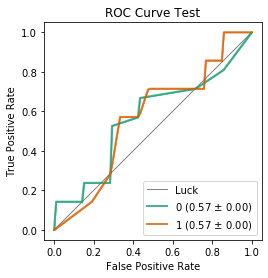

In [54]:
#showing accuracy/ROC results
fig_feat2_rf = plot_result_roc(result_feat2_rf,'ROC Curve Test')
fig_feat2_rf.savefig('ml_analysis/featImp_analysis/clr_figures/rf_fselected_test_roc.pdf',bbox_inches='tight')

acc_score = metrics.accuracy_score(y_test_feat2, feat2_rf.predict(x_test_feat2))

print('Accuracy score: {0:0.2f}'.format(
      acc_score))